In [ ]:
## Implementation of a Majority Vote Classifier
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
import six


class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """A majority vote ensemble classifier"""

    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """Fit classifiers"""
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """Predict class labels"""
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """Predict class probabilities"""
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [5]:
##Prepare the Iris dataset

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load Iris dataset
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [6]:
##Train individual classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Create individual classifiers
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# Create pipeline with standardization
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


10-fold cross validation:

ROC AUC: 0.94 (+/- 0.07) [Logistic regression]
ROC AUC: 0.90 (+/- 0.12) [Decision tree]
ROC AUC: 0.86 (+/- 0.12) [KNN]


In [7]:
##Create and evaluate the MajorityVoteClassifier

# Create majority rule classifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.94 (+/- 0.07) [Logistic regression]
ROC AUC: 0.90 (+/- 0.12) [Decision tree]
ROC AUC: 0.86 (+/- 0.12) [KNN]
ROC AUC: nan (+/- nan) [Majority voting]


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ~~~~~~~~~~~~~~~~~~~~^
        estimator, *args, response_method=response_method, **k

In [8]:
##Step 2.1: Understanding Bagging Concepts
##Bagging (Bootstrap Aggregating) builds an ensemble of classifiers trained on different bootstrap samples of the training dataset.


##Prepare Wine Dataset
# Load Wine dataset
# Load Wine dataset

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 
                   'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 
                   'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# Drop class 1 and only use classes 2 and 3
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

# Encode labels and split data
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [11]:
#Implement Bagging Classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create decision tree classifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)

# Create bagging classifier
bag = BaggingClassifier(estimator=tree, n_estimators=500, 
                        max_samples=1.0, max_features=1.0, 
                        bootstrap=True, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

# Train and evaluate individual decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


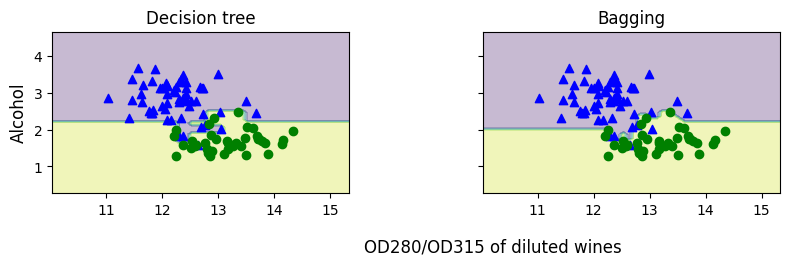

In [12]:
#visualize decision boundaries

import matplotlib.pyplot as plt
import numpy as np

# Create mesh grid for plotting
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

In [14]:
#Adaptive Boosting (AdaBoost)
#3.1: Understanding Boosting Concepts
#AdaBoost combines multiple weak learners (typically decision stumps) by focusing on misclassified samples in each iteration.
#3.2: Implementing AdaBoost classifier


from sklearn.ensemble import AdaBoostClassifier

# Create decision tree stump
tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)

# Create AdaBoost classifier
ada = AdaBoostClassifier(estimator=tree, n_estimators=500, 
                         learning_rate=0.1, random_state=1)

# Train individual decision tree stump
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree stump train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

# Train AdaBoost classifier
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))


Decision tree stump train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 0.968/0.917


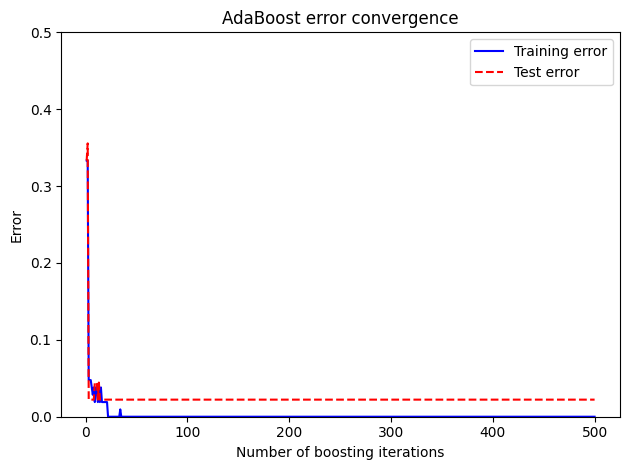

In [24]:
#Analyze Adaboost Error convergence

# Plot error convergence for AdaBoost
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=1),
                         n_estimators=500, learning_rate=1, random_state=1)

ada.fit(X_train, y_train)
ada_train_err = []
ada_test_err = []

for y_train_pred, y_test_pred in zip(ada.staged_predict(X_train), ada.staged_predict(X_test)):
    ada_train_err.append(1 - accuracy_score(y_train, y_train_pred))
    ada_test_err.append(1 - accuracy_score(y_test, y_test_pred))

plt.plot(range(1, len(ada_train_err) + 1), ada_train_err, label='Training error', color='blue', linestyle='-')
plt.plot(range(1, len(ada_test_err) + 1), ada_test_err, label='Test error', color='red', linestyle='--')
plt.xlabel('Number of boosting iterations')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.ylim(0, 0.5)
plt.title('AdaBoost error convergence')
plt.tight_layout()
plt.show()

In [16]:
#Comprehensive comparison 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

# Prepare Iris dataset for comprehensive comparison
iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create individual classifiers
clf_lr = LogisticRegression(random_state=1)
clf_knn = KNeighborsClassifier()
clf_dt = DecisionTreeClassifier(random_state=1)
clf_rf = RandomForestClassifier(random_state=1)

# Create ensemble methods
voting_clf = VotingClassifier(estimators=[
    ('lr', clf_lr), ('knn', clf_knn), ('dt', clf_dt), ('rf', clf_rf)], voting='hard')

bagging_clf = BaggingClassifier(estimator=clf_dt, n_estimators=100, random_state=1)
adaboost_clf = AdaBoostClassifier(estimator=clf_dt, n_estimators=100, random_state=1)

classifiers = [clf_lr, clf_knn, clf_dt, clf_rf, voting_clf, bagging_clf, adaboost_clf]
classifier_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 
                    'Voting Classifier', 'Bagging', 'AdaBoost']

# Evaluate all classifiers
results = []
for clf, name in zip(classifiers, classifier_names):
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    results.append({
        'Classifier': name,
        'Mean Accuracy': scores.mean(),
        'Std Accuracy': scores.std()
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values('Mean Accuracy', ascending=False))

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-lear

            Classifier  Mean Accuracy  Std Accuracy
1                  KNN       0.951818      0.048285
0  Logistic Regression       0.941818      0.047621
4    Voting Classifier       0.940909      0.065839
5              Bagging       0.940909      0.065839
3        Random Forest       0.931818      0.063278
2        Decision Tree       0.922727      0.059231
6             AdaBoost       0.922727      0.071841


In [19]:
#Hyperparameter Tuning for Ensemble Methods
# Tune AdaBoost parameters
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=1))
gs_ada = GridSearchCV(ada, param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
gs_ada.fit(X_train, y_train)

print("AdaBoost Best parameters: ", gs_ada.best_params_)
print("AdaBoost Best score: ", gs_ada.best_score_)

# Tune Bagging parameters
param_grid_bag = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

bag = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1), random_state=1)
gs_bag = GridSearchCV(bag, param_grid_bag, cv=5, scoring='accuracy', n_jobs=-1)
gs_bag.fit(X_train, y_train)

print("Bagging Best parameters: ", gs_bag.best_params_)
print("Bagging Best score: ", gs_bag.best_score_)

AdaBoost Best parameters:  {'estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 50}
AdaBoost Best score:  0.9714285714285713
Bagging Best parameters:  {'max_features': 0.8, 'max_samples': 0.5, 'n_estimators': 200}
Bagging Best score:  0.9523809523809523


1. 
Comparison: based on the reults ajority voting seem to perform better than individual models, but not always better than the best single model.

Why does the ensemble typically perform better?
By combining multiple classifiers, errors from one model are often corrected by others, reducing variance and improving stability.

Are there cases where it might perform worse?
Can be worse if base models are too similar or weak.

How does changing the number of estimators in bagging affect performance?
Number of estimators: More estimators usually improve performance by reducing variance, but after a point the gain is small while computation cost grows.

What is the effect of bootstrap sampling vs using the entire dataset?
Bootstrap sampling increases diversity among trees, making the ensemble less correlated and more effective. Using the full dataset makes trees too similar, reducing the benefit.

 Why does bagging typically reduce overfitting compared to a single decision tree?
 single decision tree tends to overfit, but bagging averages predictions over many trees, smoothing out noise and reducing variance without increasing bias.

2.
How does the learning rate parameter affect AdaBoost's performance and convergence? Analyze the error convergence plot.
High learning rate: the decisionn tree converges faster but risk of overfitting.

Low learning rate: the decision tree converges slower, more iterations needed, but often better generalization.

Why does the test error sometimes increase after many iterations?
The test error sometimes increases after many iterations because AdaBoost keeps fitting the training data more closely, including its noise and outliers. This leads to overfitting: training error continues to decrease, but the model loses generalization, so test error rises.

 What makes decision stumps good base estimators for AdaBoost?
 Very simple, high-bias classifiers.

AdaBoost reduces bias by combining many stumps.

Fast to train, diverse across iterations, and prevent overfitting too early.

3. the K-Nearest Neighbors (KNN) classifier performed best on the Iris dataset with a mean accuracy of about 95.2%, which is slightly higher than all the ensemble methods tested. This makes sense because the Iris dataset is small, low-dimensional, and well-separated, so a simple distance-based method like KNN can perform very well without the need for complex ensembles

Random Forest vs Bagging: Random Forest is a type of bagging with an extra step of random feature selection at splits. This reduces correlation between trees, but on a small dataset like Iris it may slightly hurt performance.

When to choose methods:

Bagging/Random Forest: reduce variance with unstable learners (e.g., decision trees).

Boosting: reduce bias, good for harder datasets.

Voting: combine diverse strong models.
4. Computational Trade-offs

Bagging (e.g., Random Forests):
Each model is trained independently, so it can be parallelized easily. Training many models takes time, but prediction is just averaging.

Boosting (e.g AdaBoost):
Models are trained sequentially, so it is slower and harder to parallelize. However, it usually needs fewer models to reach high accuracy.

Ensemble Size and Bias–Variance

Increasing the number of models in bagging reduces variance since predictions are averaged, but the bias stays the same.

In boosting, adding more models reduces bias because each model corrects the last one, but if you add too many, the variance may increase due to overfitting.

Real-world Scenarios

Bagging : Good for noisy datasets, tabular data, and when interpretability (feature importance) is useful. Example: fraud detection, medical risk scoring.

Boosting: Best for accuracy on structured data. Example: customer churn, click prediction, Kaggle competitions.